<a href="https://colab.research.google.com/github/jban28/MPhys-Radiotherapy-49/blob/main/Trying3dAugSem2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pre-requisites
This block makes the necessary installations and imports for the rest of the code blocks to run, connects to the GPU if one is available, and specifies the location of the folder containing the data. That data folder should contain a sub-folder containing all nifti files, along with a metadata csv file.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torch torchvision
!pip install opencv-contrib-python
!pip install scikit-learn
!pip install SimpleITK
!pip install kornia
!pip install utils
!pip install torchio

import numpy as np
import random
import os
import matplotlib.pyplot as plt
import SimpleITK as sitk
import torch
import torchio as tio
import kornia.augmentation as K
import torch.nn.functional as F

from mpl_toolkits.mplot3d import Axes3D
from torch.nn import Module
from torch.nn import Conv3d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch.nn import LeakyReLU
from torch import flatten
from torch import nn
from torch import reshape
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
from torch.optim import Adam
import torchvision.models as models
from torchvision.io import read_image
from torchsummary import summary
from scipy.ndimage import zoom, rotate
#from torch.utils.data import windowLevelNormalize


# Connect to GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

# Specify project folder location
#project_folder = "/content/drive/My Drive/Degree/MPhys/Data/"
project_folder = "/content/drive/My Drive/Data/"

     |████████████████████████████████| 48.4 MB 19 kB/s 
     |████████████████████████████████| 474 kB 4.1 MB/s 
     |████████████████████████████████| 164 kB 4.2 MB/s 
Using cuda device


## Define arrays of patient and outcome data
This block allows you to specify the criteria which defines the patient outcome as True or False. It then loops through all the patients in the metadata.csv file, searches for their corresponding image in the image folder, and then adds patient and outcome to either the training, testing, or validation array

In [3]:
# Open the metadata.csv file, convert to an array, and remove column headers
metadata_file = open(project_folder + "metadata.csv")
metadata = np.loadtxt(metadata_file, dtype="str", delimiter=",")
metadata = metadata[1:][:]

# Set the values which are used to define the outcome for each patient
outcome_type = 1 #int(input("Select which outcome you are aiming to predict \n(1=Locoregional, 2=Distant Metastasis, 3=Death):"))
check_day = 3000 #int(input("Select the number of days at which to check for event:"))
which_patients = 1 #int(input("Do you want to include patients whose last follow up is before the check day? (no = 0, yes = 1):"))

# Create empty arrays to store patient names and outcomes in
patient_with_event = []
patient_no_event = []
outcomes_train = []
outcomes_test = []
images = []

# Loop through each patient and identify whether they are true or false for the specified outcome from above
for patient in metadata:
  if (patient[(5+outcome_type)] == "") and (int(patient[5]) >= check_day):
    # Last follow up after check day, no event
    outcome = 0
  elif (patient[(5+outcome_type)] == "") and (int(patient[5]) < check_day) and (which_patients == 0):
    # Last follow up before check day, event unknown
    continue
  elif (patient[(5+outcome_type)] == "") and (int(patient[5]) < check_day) and (which_patients == 1):
    outcome = 0
  elif int(patient[(5+outcome_type)]) <= check_day:
    # Event occurred before or on check day
    outcome = 1
  else:
    # Event occurred after check day
    outcome = 0
  # No Image file found for patient
  if not os.path.exists(project_folder + "crop/Images/" + patient[0] + ".nii"):
    print("No image found for patient " + patient[0])
    continue
  
  if outcome == 1:
    patient_with_event.append([patient[0], outcome])
  else:
    patient_no_event.append([patient[0], outcome])

# # Make arrays the same length
# if len(patient_with_event) < len(patient_no_event):
#   new_patient_no_event = random.sample(patient_no_event,len(patient_with_event))
#   new_patient_with_event = patient_with_event
# elif len(patient_with_event) > len(patient_no_event):
#   new_patient_with_event = random.sample(patient_with_event, len(patient_no_event))
#   new_patient_no_event = patient_no_event
# elif len(patient_with_event) == len(patient_no_event):
new_patient_no_event = patient_no_event
new_patient_with_event = patient_with_event
pos_weights = len(new_patient_no_event)/len(new_patient_with_event)
# Add patient name, outcome and image to array
seventy_percent_event = int(0.7*len(new_patient_with_event))
seventy_percent_no_event = int(0.7*len(new_patient_no_event))

print('NO event')
print(len(new_patient_no_event))
print('WITH event')
print(len(new_patient_with_event))
train_patients_event = random.sample(new_patient_with_event, seventy_percent_event)
train_patients_no_event = random.sample(new_patient_no_event, seventy_percent_no_event)

def remove(small_array, original_array):
  for i in small_array:
    original_array.remove(i)
    
  return original_array

new_patients_with_event = remove(train_patients_event, new_patient_with_event)
new_patient_no_event = remove(train_patients_no_event, new_patient_no_event)

print('NO event')
print(len(new_patient_no_event))
print('WITH event')
print(len(new_patient_with_event))


fifty_percent_event = int(0.5*len(new_patient_with_event))
fifty_percent_no_event = int(0.5*len(new_patient_no_event))

validate_patients_event = random.sample(new_patient_with_event, fifty_percent_event)
validate_patients_no_event = random.sample(new_patient_no_event, fifty_percent_no_event)

new_patient_with_event = remove(validate_patients_event, new_patient_with_event)
new_patient_no_event = remove(validate_patients_no_event, new_patient_no_event)

print('NO event')
print(len(new_patient_no_event))
print('WITH event')
print(len(new_patient_with_event))

test_patients_event = new_patient_with_event
test_patients_no_event = new_patient_no_event

outcomes_train = train_patients_event + train_patients_no_event
outcomes_validate = validate_patients_event + validate_patients_no_event
outcomes_test = test_patients_event + test_patients_no_event

print(outcomes_train)
print(outcomes_validate)
print(outcomes_test)



No image found for patient HN-CHUM-005
No image found for patient HN-CHUM-016
No image found for patient HN-CHUM-040
No image found for patient HN-CHUM-051
No image found for patient HN-CHUS-033
No image found for patient HN-CHUS-086
No image found for patient HN-CHUS-089
No image found for patient HN-CHUS-093
No image found for patient HN-CHUS-096
No image found for patient HN-CHUS-099
No image found for patient HN-CHUS-100
No image found for patient HN-CHUS-101
No image found for patient HN-HGJ-003
No image found for patient HN-HGJ-008
No image found for patient HN-HGJ-010
No image found for patient HN-HGJ-028
No image found for patient HN-HGJ-034
No image found for patient HN-HGJ-038
No image found for patient HN-HGJ-041
No image found for patient HN-HGJ-046
No image found for patient HN-HGJ-047
No image found for patient HN-HGJ-048
No image found for patient HN-HGJ-054
No image found for patient HN-HGJ-055
No image found for patient HN-HGJ-056
No image found for patient HN-HGJ-063


## Define dataset class
This block defines the class on which to build dataset objects

In [57]:
class Normalize(Dataset):
    def __init__(self):
      pass
    def __call__(self, vol):
        vol = (vol-vol.mean())/vol.std()
        return(vol) 

# class MyAugmentationPipeline(Dataset):
# #class MyAugmentationPipeline(nn.Module):
#     def __init__(self):
#         super(MyAugmentationPipeline, self).__init__()
#         #self.mixup = K.RandomMixUp(p=1.)
#         self.aff = K.RandomAffine3D(degrees=[5.,5.,5.], scale=(0.9,1.1), keepdim = True, p=0.5)
#         self.Hflip = K.RandomHorizontalFlip3D(p=0.3)
#         # self.jitter = K.ColorJitter(0.2, 0.3, 0.2, 0.3, p=0.5)
#         # self.crp = K.RandomCrop((200, 200))
#     #def forward(self, input, label):
#     def __call__(self, input):
#         #input, label = self.mixup(input, label)
#         input = self.aff(self.Hflip)
#         #input = self.crp(self.jitter(self.aff(input)))
#         #return input, label
#         return input
# aug = MyAugmentationPipeline()


data_transform = transforms.Compose([
        transforms.ToTensor(),
        Normalize()
    ])

#window and levelling
def windowLevelNormalize(image, level, window):
    minval = level - window/2
    maxval = level + window/2
    wld = np.clip(image, minval, maxval)
    wld -= minval
    wld *= (1 / window)
    return wld

# transforms = (
#     tio.RandomFlip(axes=['LR'], flip_probability = 0.5), 
#     tio.RandomAffine(scales=(3/4, 4/3), degrees=0, translation=0,)
# )
# augtransform = tio.Compose(transforms)
#augtransform = tio.RandomFlip(axes=['LR'], flip_probability = 1.0)

class ImageDataset(Dataset):
    def __init__(self, annotations, img_dir, transform= data_transform, target_transform=None, rotate_augment=False, scale_augment=False, flip_augment=True):
        self.img_labels = annotations
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.flips = flip_augment
        self.rotations = rotate_augment
        self.scaling = scale_augment

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels[idx][0]+".nii")
        image_sitk = sitk.ReadImage(img_path)
        image = sitk.GetArrayFromImage(image_sitk)
        label = self.img_labels[idx][1]
        print(image.shape)
        



        if self.target_transform:
            label = self.target_transform(label)

        
        if self.rotations and random.random()<0.5:
            # taking implementation from my 3DSegmentationNetwork which can be applied -> rotations in the axial plane only I should think? -10->10 degrees?
            roll_angle = np.clip(np.random.normal(loc=0,scale=3), -10, 10) # make -10,10
            image = self.rotation(image, roll_angle, rotation_plane=(1,2)) # (1,2) originally
            print('rotation')
            
        if self.scaling and random.random()<0.5:
            # same here -> zoom between 80-120%
            scale_factor = np.clip(np.random.normal(loc=1.0,scale=0.5), 0.8, 1.2) # original scale = 0.05
            image = self.scale(image, scale_factor)
            print('scale')
            
        if self.flips and random.random()<1.0:
            image = self.flip(image)
            print('horizontal flip')
        if self.transform:
            image = self.transform(image)

        # window and levelling
        #image = windowLevelNormalize(image, level=40, window=50)
        return image, label
    def scale(self, image, scale_factor):
        # scale the image or mask using scipy zoom function
        order, cval = (3, 0) # changed from -1024 to 0
        height, width, depth = image.shape
        zheight = int(np.round(scale_factor*height))
        zwidth = int(np.round(scale_factor*width))
        zdepth = int(np.round(scale_factor*depth))
        # zoomed out
        if scale_factor < 1.0:
            new_image = np.full_like(image, cval)
            ud_buffer = (height-zheight) // 2
            ap_buffer = (width-zwidth) // 2
            lr_buffer = (depth-zdepth) // 2
            new_image[ud_buffer:ud_buffer+zheight, ap_buffer:ap_buffer+zwidth, lr_buffer:lr_buffer+zdepth] = zoom(input=image, zoom=scale_factor, order=order, mode='constant', cval=cval)[0:zheight, 0:zwidth, 0:zdepth]
            return new_image
        elif scale_factor > 1.0:
            new_image = zoom(input=image, zoom=scale_factor, order=order, mode='constant', cval=cval)[0:zheight, 0:zwidth, 0:zdepth]
            ud_extra = (new_image.shape[0] - height) // 2
            ap_extra = (new_image.shape[1] - width) // 2
            lr_extra = (new_image.shape[2] - depth) // 2
            new_image = new_image[ud_extra:ud_extra+height, ap_extra:ap_extra+width, lr_extra:lr_extra+depth]
            return new_image
        return image
      
    def rotation(self, image, rotation_angle, rotation_plane):
        # rotate the image using scipy rotate function
        order, cval = (3, -1024) # changed from -1024 to 0
        return rotate(input=image, angle=rotation_angle, axes=rotation_plane, reshape=False, order=order, mode='constant', cval=cval)

    def flip(self, image):
        #hflip = np.fliplr(image)
        #image = (reversed(image[1:]))
        image = np.flipud(image).copy()
        return image


## Build Datasets
This block uses the class and arrays defined previously to build datasets for training, testing and validation.

In [58]:

training_data = ImageDataset(outcomes_train, project_folder + "crop/Images/")
validation_data = ImageDataset(outcomes_validate, project_folder + "crop/Images/")
test_data = ImageDataset(outcomes_test, project_folder + "crop/Images/")
print(len(training_data))


97


## View binary masks in 3d
This block allows you to view a binary mask from the image in 3d by extracting the image from a given dataset. This helps to confirm that the data has not been affected by reading in to pytorch.

flipud
['HN-HGJ-078', 1]
(246, 246, 246)
horizontal flip
<class 'torch.Tensor'>
array shape
torch.Size([246, 246, 246])


(0.0, 246.0)

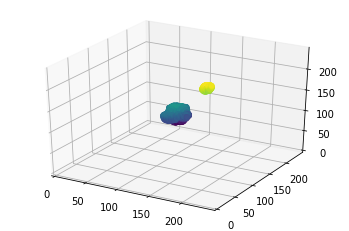

In [59]:
# Set which dataset to look at, and the index of the patient to view
dataset = training_data
index = 9
print('flipud')
print(outcomes_train[index])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#print(dataset[0])

#array = dataset[index][0].numpy()
array = dataset[index][0]
print(type(array))
print('array shape')
print(array.shape)
x,y,z = np.where(array > 0.) # what >=
ax.scatter(x, y, z, c=z, alpha=1)

ax.set_xlim(0,246)
ax.set_ylim(0,246)
ax.set_zlim(0,246)


# Dataloader

In [11]:
train_dataloader = DataLoader(training_data, batch_size=2, shuffle=True)
validate_dataloader = DataLoader(validation_data, batch_size=2, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=2, shuffle=True)


# Define CNN Class

In [12]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    out1 = 4
    out2 = 4
    out3 = 2
    self.cnn_layers = nn.Sequential(
      # Layer 1
      nn.Conv3d(1,out1,4,1,1),
      nn.BatchNorm3d(out1),
      #nn.ReLU(inplace=True),
      nn.LeakyReLU(inplace=True),
      nn.MaxPool3d(kernel_size=2, stride=2),
      # Layer 2
      nn.Conv3d(out1, out2, 4, 1, 1),
      nn.BatchNorm3d(out2),
      #nn.ReLU(inplace=True),
      nn.LeakyReLU(inplace=True),
      nn.MaxPool3d(kernel_size=2, stride=2),
      # Layer 3
      nn.Conv3d(out2, out3, 4, 1, 1),
      nn.BatchNorm3d(out3),
      #nn.ReLU(inplace=True),
      nn.LeakyReLU(inplace=True),
      nn.MaxPool3d(kernel_size=2, stride=2),
    )
    self.linear_layers = nn.Sequential(
      nn.Linear(48778, 2)
    )
  def forward(self, x):
    x = self.cnn_layers(x)
    x = x.view(x.size(0), -1)
    x = self.linear_layers(x)
    return x

model = CNN().to(device)
print(model)


CNN(
  (cnn_layers): Sequential(
    (0): Conv3d(1, 4, kernel_size=(4, 4, 4), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv3d(4, 4, kernel_size=(4, 4, 4), stride=(1, 1, 1), padding=(1, 1, 1))
    (5): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01, inplace=True)
    (7): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv3d(4, 2, kernel_size=(4, 4, 4), stride=(1, 1, 1), padding=(1, 1, 1))
    (9): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01, inplace=True)
    (11): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0

# Define Train and Test Loops

In [13]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X = reshape(X, (X.shape[0],1,246,246,246))
        X = X.float()
        X = X.to(device)
        y = y.to(device)
        #y = reshape(y, (y.shape[0],1))
        hot_y = torch.empty((X.shape[0],2)).to(device)
        for index in range(len(y)):
          if y[index] == 0:
            hot_y[index,0] = 1
            hot_y[index,1] = 0
          elif y[index] == 1:
            hot_y[index,0] = 0
            hot_y[index,1] = 1
      
        print(hot_y)
        pred = model(X)
        torch.squeeze(pred)
        loss = loss_fn(pred, hot_y.float())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print results after each batch        
        if batch % 1 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss

def validate_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    validate_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = reshape(X, (X.shape[0],1,246,246,246))
            X = X.float()
            X = X.to(device)
            y = y.to(device)
            #y = reshape(y, (y.shape[0],1))
            hot_y = torch.empty((X.shape[0],2)).to(device)
            for index in range(len(y)):
              if y[index] == 0:
                hot_y[index,0] = 1
                hot_y[index,1] = 0
              elif y[index] == 1:
                hot_y[index,0] = 0
                hot_y[index,1] = 1
            
            pred = model(X)
            # print(f'pred: {pred}')
            # print(f'hot_y: {hot_y}')
            _,predictions = torch.max(pred , 1)
            _,targets = torch.max(hot_y, 1)
            # print(f'predictions: {predictions}')
            # print(f'targets: {targets}')
            print(f'Correct this batch = {(predictions == targets).sum().item()}')

            torch.squeeze(pred)
            validate_loss += loss_fn(pred, hot_y.float()).item()
            # correct += (pred.argmax(1) == hot_y).type(torch.float).sum().item()
            correct += (predictions == targets).sum().item()

    validate_loss /= num_batches
    correct /= size
    accuracy = 100*correct
    print(f"Validate Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {validate_loss:>8f} \n")
    return validate_loss, accuracy

learning_rate = 0.001
# defining the model
model = CNN()
# defining the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# defining the loss function
pos_weights = torch.tensor(pos_weights)
loss_fn = nn.BCEWithLogitsLoss(pos_weights)
# loss_fn = nn.CrossEntropyLoss()

model.to(device)
loss_fn.to(device)

summary(model=model, input_size=(1, 246, 246, 246), batch_size=2)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1      [2, 4, 245, 245, 245]             260
       BatchNorm3d-2      [2, 4, 245, 245, 245]               8
         LeakyReLU-3      [2, 4, 245, 245, 245]               0
         MaxPool3d-4      [2, 4, 122, 122, 122]               0
            Conv3d-5      [2, 4, 121, 121, 121]           1,028
       BatchNorm3d-6      [2, 4, 121, 121, 121]               8
         LeakyReLU-7      [2, 4, 121, 121, 121]               0
         MaxPool3d-8         [2, 4, 60, 60, 60]               0
            Conv3d-9         [2, 2, 59, 59, 59]             514
      BatchNorm3d-10         [2, 2, 59, 59, 59]               4
        LeakyReLU-11         [2, 2, 59, 59, 59]               0
        MaxPool3d-12         [2, 2, 29, 29, 29]               0
           Linear-13                     [2, 2]          97,558
Total params: 99,380
Trainable params: 

# Run Network

In [14]:
epochs = 2
train_losses = [[],[]]
validate_losses = [[],[]]
validate_accuracies = [[],[]]
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    validate_loss = validate_loop(validate_dataloader, model, loss_fn)

    train_losses[0].append(t)
    train_losses[1].append(train_loss)
    validate_losses[0].append(t)
    validate_losses[1].append(validate_loss[0])
    validate_accuracies[0].append(t)
    validate_accuracies[1].append(validate_loss[1])
print("Done!")



Epoch 1
-------------------------------
(246, 246, 246)
horizontal flip
(246, 246, 246)
horizontal flip


RuntimeError: ignored

# Test

In [ ]:
def test_loop(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = reshape(X, (X.shape[0],1,246,246,246))
            X = X.float()
            X = X.to(device)
            y = y.to(device)
            #y = reshape(y, (y.shape[0],1))
            hot_y = torch.empty((X.shape[0],2)).to(device)
            for index in range(len(y)):
              if y[index] == 0:
                hot_y[index,0] = 1
                hot_y[index,1] = 0
              elif y[index] == 1:
                hot_y[index,0] = 0
                hot_y[index,1] = 1
                
            pred = model(X)
            _,predictions = torch.max(pred , 1)
            _,targets = torch.max(hot_y, 1)
            torch.squeeze(pred)
            #test_loss += loss_fn(pred, y.float()).item()
            test_loss += loss_fn(pred, hot_y.float()).item()
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            correct += (predictions == targets).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss

test_loop(test_dataloader, model)

# Plot Losses

In [ ]:
fig = plt.figure()
ax = plt.axes()
ax.plot(train_losses[0], train_losses[1], label="Train Loss")
ax.plot(validate_losses[0], validate_losses[1], label="Validate Loss")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

# Plot Accuracies

In [ ]:
fig = plt.figure()
ax = plt.axes()
ax.plot(validate_accuracies[0], validate_accuracies[1], label="Validate Accuracies")
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy / %')
ax.legend()